# Libraries import

In [1]:
import numpy as np # linear algebra
import pandas as pd 
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt  # Matlab-style plotting
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
sns.set(style='white', context='notebook', palette='deep')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
Random_state=42
np.random.seed(0)

In [2]:
#Models import
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#import imputer:
from sklearn.impute import KNNImputer
#score
from sklearn.metrics import f1_score
from sklearn.ensemble import StackingClassifier

read the dataset and convert the label (status) to binary


In [3]:
dataset=pd.read_csv("../input/startup-success-prediction/startup data.csv",\
                    converters={'status': lambda x: int(x == 'acquired')},parse_dates=['founded_at','first_funding_at','last_funding_at'])
dataset.head()


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,1
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,1
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,1
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,1
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,0


Changeing the label column name from "status" to "is_acquired" ,
for binary classification

In [4]:
dataset.rename(columns={'status':'is_acquired'}, inplace=True)

# MODELING


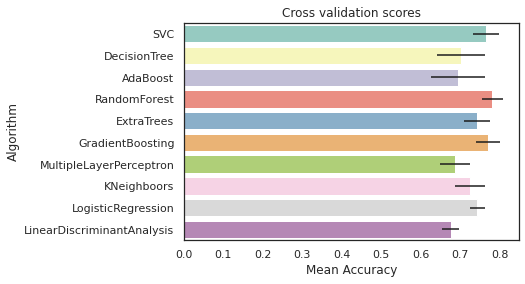

In [17]:
y=dataset["is_acquired"]
X= dataset.loc[:, dataset.columns != 'is_acquired']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
plt.show()

I decided to choose the SVC ,RandomForest,ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.


In [ ]:
best_classifiers=[]
# Adaboost

### META MODELING
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
print("Adaboost score: "+str(gsadaDTC.best_score_))


### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

best_classifiers.append(SVMC_best)

# Best score
SVC_score = gsSVMC.best_score_

print(f' SVC classifier score is :{SVC_score}')

#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [1,2,4],
              "max_features": [1,100,1000],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

best_classifiers.append(ExtC_best)

# Best score

ExtraTrees_score= gsExtC.best_score_

print(f' ExtraTrees score is :{ExtraTrees_score}')

# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [1,2,4],
              "max_features": [1, 10,100,1000],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_
best_classifiers.append(RFC_best)

# Best score

RandomForests_score= gsRFC.best_score_

print(f' RandomForests score is :{RandomForests_score}')

# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,1000],
              'learning_rate': [0.001,0.1, 0.05, 0.01,1,10],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_
best_classifiers.append(GBC_best)

# Best score

GradientBoosting_score= gsGBC.best_score_

print(f' GradientBoosting score is :{GradientBoosting_score}')

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Adaboost score: 0.7317289892632358
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s


## Interactive feature importances via Plotly scatterplots



Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.



In [ ]:
def plotly_scatterplots(model_importances,model_title):
    trace = go.Scatter(
        y = feature_dataframe[model_importances].values,
        x = feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = feature_dataframe[model_importances].values,
            colorscale='Portland',
            showscale=True
        ),
        text = feature_dataframe['features'].values
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= model_title,
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [ ]:
# Create a dataframe with features

cols = X_train.columns.values

rf_feature = RFC_best.feature_importances_
et_feature = ExtC_best.feature_importances_
ada_feature = ada_best.feature_importances_
gb_feature = GBC_best.feature_importances_

feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })
feature_dataframe = feature_dataframe[feature_dataframe.astype(bool).sum(axis=1) > feature_dataframe.shape[1]/(1.2)]
model_importances=['Random Forest feature importances','Extra Trees  feature importances','AdaBoost feature importances','Gradient Boost feature importances']
model_title=['Random Forest feature importance','Extra Trees  feature importance','AdaBoost feature importance','Gradient Boost feature importance']

for importances,title in zip(model_importances,model_title):
    
    plotly_scatterplots(importances,title)
    

In [ ]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

In [ ]:
def mean_bar_plot(feature_dataframe):
    y = feature_dataframe['mean'].values
    x = feature_dataframe['features'].values
    data = [go.Bar(
                x= x,
                 y= y,
                width = 0.5,
                marker=dict(
                   color = feature_dataframe['mean'].values,
                colorscale='Portland',
                showscale=True,
                reversescale = False
                ),
                opacity=0.6
            )]

    layout= go.Layout(
        autosize= True,
        title= 'Barplots of Mean Feature Importance',
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='bar-direct-labels')

In [ ]:
mean_bar_plot(feature_dataframe)

## Plot learning curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)



Feature importance of tree based classifiers


In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        


test_is_acquired_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_is_acquired_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_is_acquired_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_is_acquired_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")

Concatenate all classifier results


In [ ]:
ensemble_results = pd.concat([test_is_acquired_RFC,test_is_acquired_ExtC,test_is_acquired_AdaC,test_is_acquired_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

# Ensemble modeling

## Combining models

In [ ]:
#voting Classifier:
 
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best)
,('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

#stacking
def stacking(classifiers, X_train, X_test, y_train, y_test):
    all_estimators = []
    for classifier in classifiers:
        all_estimators.append((str(classifier), classifier))
    stack = StackingClassifier(estimators=all_estimators, final_estimator=GBC_best)
    score= stack.fit(X_train, y_train).score(X_test, y_test)
   
    return score


# Prediction

In [ ]:
test_is_acquired = pd.Series(votingC.predict(X_test), name="is_acquired")

results = pd.concat([test_is_acquired],axis=1)

score= f1_score(y_test, results, average='macro')

stacking_score = stacking(best_classifiers, X_train, X_test, y_train, y_test)

print(f'the voting score is: {score}')

print(f'the stacking score is: {stacking_score} ') 

We can clearly see stacking gave best classification score results